In [1]:
import datetime
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import scipy
import seaborn as sns
import sklearn
from sklearn import *
import statsmodels as sm

np.random.seed(1337)

%matplotlib inline

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

## Movies

In [2]:
movies = pd.read_csv('data/ml-latest-small/movies.csv')
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
title      9742 non-null object
genres     9742 non-null object
dtypes: int64(1), object(2)
memory usage: 228.4+ KB


In [3]:
movies.columns = ['movie_id', 'title', 'genres']

In [4]:
movies.sample(10)

,movie_id,title,genres
8755,128099,Jim Jefferies: BARE (2014),Comedy
8779,128991,Johnny Express (2014),Animation|Comedy|Sci-Fi
9383,163527,Comedy Central Roast of David Hasselhoff (2010),Comedy
5200,8464,Super Size Me (2004),Comedy|Documentary|Drama
3605,4952,Morons From Outer Space (1985),Comedy|Sci-Fi
5290,8753,Unprecedented: The 2000 Presidential Election ...,Documentary
2724,3658,Quatermass and the Pit (1967),Horror|Sci-Fi
205,239,"Goofy Movie, A (1995)",Animation|Children|Comedy|Romance
3815,5345,Triumph of the Spirit (1989),Drama
8991,139415,Irrational Man (2015),Crime|Drama


In [5]:
year_pattern = re.compile(r'.*\((\d+)\)')
def parse_year(title):
    try:
        return int(year_pattern.match(title).group(1))
    except:
        return None
movies['year'] = movies.title.apply(parse_year)

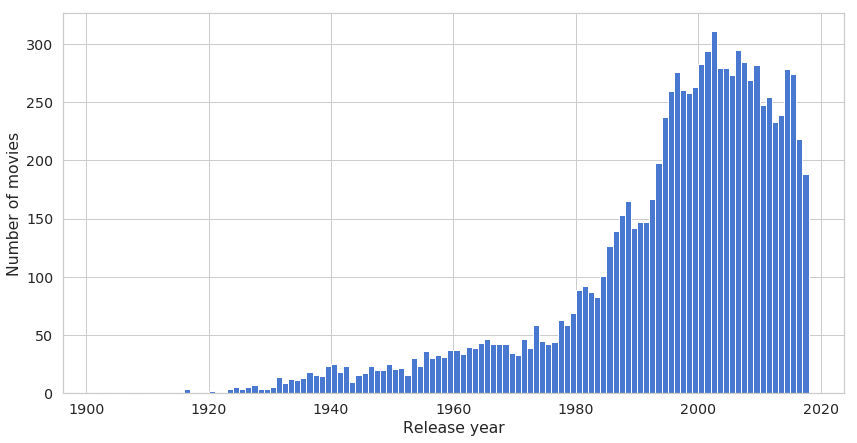

In [6]:
plt.figure(figsize=(14, 7))
years = movies.year.dropna().tolist()
bins = int(np.max(years) - np.min(years))
plt.hist(years, bins=bins)
plt.xlabel('Release year')
plt.ylabel('Number of movies')
plt.show()

In [7]:
all_genres = set()
def parse_genres(genres):
    ret = []
    for genre in genres.split('|'):
        genre = re.sub('[^a-z]', '', genre.lower())
        ret.append(genre)
        all_genres.add(genre)
    return ret
movies['parsed_genres'] = movies.genres.apply(parse_genres)
del movies['genres']
for genre in all_genres:
    movies['genre_{0}'.format(genre)] = movies.parsed_genres.apply(lambda genres: int(genre in genres))

In [8]:
movies.sum()

movie_id                                                        411115845
title                   Toy Story (1995)Jumanji (1995)Grumpier Old Men...
year                                                          1.94056e+07
parsed_genres           [adventure, animation, children, comedy, fanta...
genre_scifi                                                           980
genre_imax                                                            158
genre_western                                                         167
genre_comedy                                                         3756
genre_fantasy                                                         779
genre_action                                                         1828
genre_war                                                             382
genre_children                                                        664
genre_animation                                                       611
genre_horror                          

In [9]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 24 columns):
movie_id                9742 non-null int64
title                   9742 non-null object
year                    9729 non-null float64
parsed_genres           9742 non-null object
genre_scifi             9742 non-null int64
genre_imax              9742 non-null int64
genre_western           9742 non-null int64
genre_comedy            9742 non-null int64
genre_fantasy           9742 non-null int64
genre_action            9742 non-null int64
genre_war               9742 non-null int64
genre_children          9742 non-null int64
genre_animation         9742 non-null int64
genre_horror            9742 non-null int64
genre_nogenreslisted    9742 non-null int64
genre_documentary       9742 non-null int64
genre_romance           9742 non-null int64
genre_adventure         9742 non-null int64
genre_filmnoir          9742 non-null int64
genre_crime             9742 non-null int64
genre_dra

## Tags

In [10]:
tags = pd.read_csv('data/ml-latest-small/tags.csv')
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
userId       3683 non-null int64
movieId      3683 non-null int64
tag          3683 non-null object
timestamp    3683 non-null int64
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [11]:
tags.columns = ['user_id', 'movie_id', 'tag', 'timestamp']

In [12]:
tags.sample(10)

,user_id,movie_id,tag,timestamp
582,318,4708,reciprocal spectator,1416086490
256,62,99114,Great performances,1526078768
2350,474,8446,World War II,1137375442
3134,567,58301,dark humor,1525283360
2048,474,5971,anime,1138039281
236,62,87430,space,1525555182
227,62,71535,Jesse Eisenberg,1529777186
3089,567,8335,heartbreaking,1525285746
1889,474,4210,Hannibal Lecter,1139059882
3372,599,293,Natalie Portman,1498456126


## Ratings

In [13]:
ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [14]:
ratings.columns = ['user_id', 'movie_id', 'rating', 'timestamp']

In [15]:
ratings.sample(10)

,user_id,movie_id,rating,timestamp
96855,603,3246,4.0,953927375
11992,73,112556,4.0,1464197220
45740,304,60,1.0,891174024
31898,219,7319,1.5,1198783202
58201,381,1722,3.5,1167542247
18761,120,733,4.0,860070029
76871,480,8641,4.5,1179164266
96087,602,590,3.0,840875508
26546,182,2890,3.5,1054780332
25968,180,2761,4.0,1270237599


count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


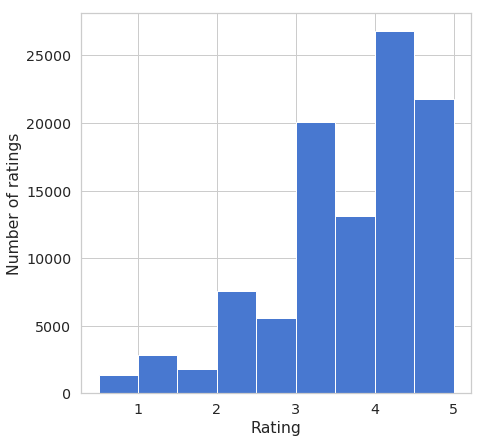

In [16]:
print(ratings.rating.describe())
plt.figure(figsize=(7, 7))
plt.hist(ratings.rating, bins=9)
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.show()

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: movie_id, dtype: float64


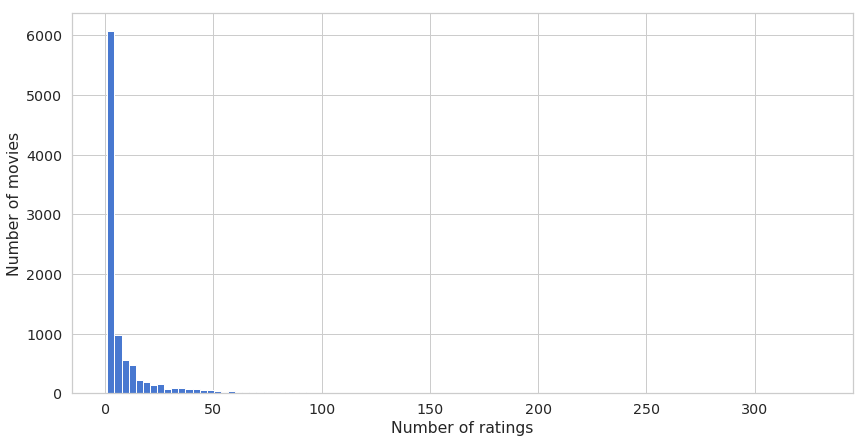

In [17]:
n_ratings = ratings.groupby(['movie_id']).movie_id.count()
print(n_ratings.describe())
plt.figure(figsize=(14, 7))
plt.hist(n_ratings, bins=100)
plt.xlabel('Number of ratings')
plt.ylabel('Number of movies')
plt.show()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: movie_id, dtype: float64


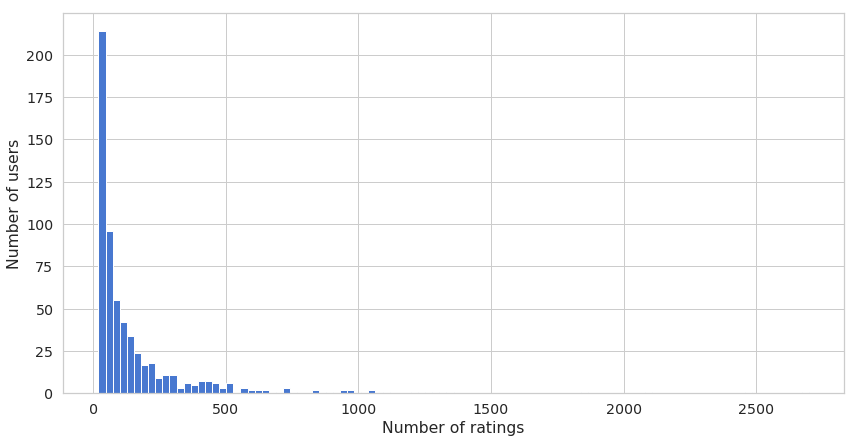

In [18]:
n_ratings = ratings.groupby(['user_id']).movie_id.count()
print(n_ratings.describe())
plt.figure(figsize=(14, 7))
plt.hist(n_ratings, bins=100)
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show()

In [19]:
ratings['year'] = ratings.timestamp.apply(lambda ts: datetime.datetime.fromtimestamp(ts).year)

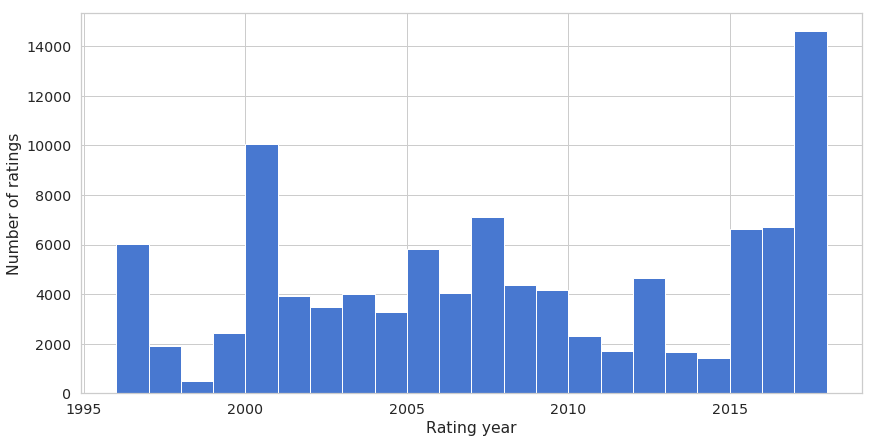

In [20]:
plt.figure(figsize=(14, 7))
years = ratings.year.dropna().tolist()
bins = int(np.max(years) - np.min(years))
plt.hist(years, bins=bins)
plt.xlabel('Rating year')
plt.ylabel('Number of ratings')
plt.show()

In [21]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 5 columns):
user_id      100836 non-null int64
movie_id     100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
year         100836 non-null int64
dtypes: float64(1), int64(4)
memory usage: 3.8 MB


In [22]:
movies.to_csv('data/movies_clean.csv', index=False)
ratings.to_csv('data/ratings_clean.csv', index=False)

In [23]:
ratings = ratings.sample(frac=1.0)
train_lim = int(0.8 * len(ratings))
ratings[:train_lim].to_csv('data/ratings_train.csv', index=False)
ratings[train_lim:].to_csv('data/ratings_test.csv', index=False)